In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)


import time
from capytaine_generator import CapytaineSlantSolver
import capytaine as cpt

<class 'module'>
['c:\\Users\\15183\\miniconda3\\envs\\openflash-env\\Lib\\site-packages\\openflash']
c:\Users\15183\miniconda3\envs\openflash-env\Lib\site-packages\openflash\__init__.py
OpenFLASH modules imported successfully!


In [99]:
css = CapytaineSlantSolver(True, True, False, False, False)
def compute_cpt_slant(config):
  t_densities = [30, 60]
  respack = css.construct_and_solve(config["a"], config["d_in"], config["d_out"], config["heaving"], t_densities, 50, config["h"], config["omega"], config["rho"], 1)
  am, dp, f_ex = (respack[0].added_mass)["Heave"], (respack[0].radiation_damping)["Heave"], (cpt.assemble_dataset([respack[2]]))["excitation_force"][0][0][0].values
  return am, dp, f_ex

In [47]:
# Run Settings

h = 100.00 # sea depth [m]
omega_sweep = np.linspace(0.4, 1.5, 10) # rad/s
rho = 1023 #keep this

# RM3
heaving_list_sweep = [False, True]
d_list = [42-2, 2] # drafts [m] 
a_list = [3, 10] # radii [m]
NMK = [100, 100, 100] # number of coefficients in each region 


In [48]:
# Run MEEM

# 1. Create SteppedBody objects
bodies_sweep = []
for i in range(len(a_list)):
    body = SteppedBody(
        a=np.array([a_list[i]]),
        d=np.array([d_list[i]]),
        slant_angle=np.array([0.0]),
        heaving=heaving_list_sweep[i]
    )
    bodies_sweep.append(body)

# 2. Create arrangement
arrangement_sweep = ConcentricBodyGroup(bodies_sweep)

# 3. Create geometry
geometry_sweep = BasicRegionGeometry(
    body_arrangement=arrangement_sweep,
    h=h,
    NMK=NMK
)

# 4. Create the MEEMProblem instance
problem_sweep = MEEMProblem(geometry_sweep)

# 5. Set the frequencies for the sweep
problem_sweep.set_frequencies(omega_sweep)

# 6. Initialize a new MEEM Engine for this problem
engine_sweep = MEEMEngine(problem_list=[problem_sweep])

# --- 3.2. Run the Full Sweep ---
results_obj_sweep = engine_sweep.run_and_store_results(problem_index=0)

# Get the xarray.Dataset
ds_sweep = results_obj_sweep.get_results()

# Extract the Added Mass and Damping matrices.
# These are 3D arrays: (frequency, mode_j, mode_i)
# A[freq, 1, 0] = Added Mass on body 1 due to motion of body 0
A_MEEM = ds_sweep.added_mass
B_MEEM = ds_sweep.damping

KeyboardInterrupt: 

0


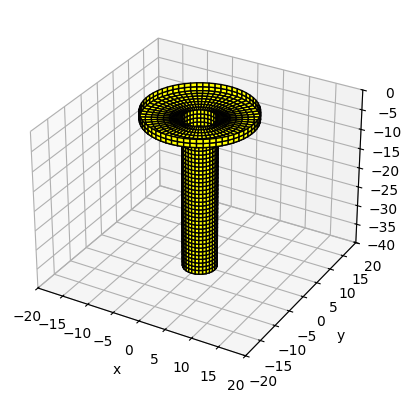

Panel Count:  1770
1


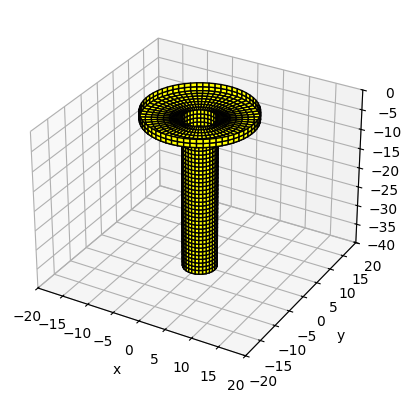

Panel Count:  1770
2


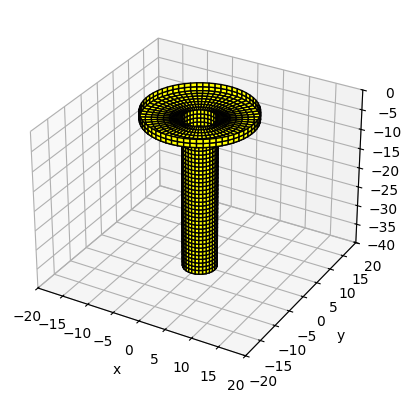

Panel Count:  1770
3


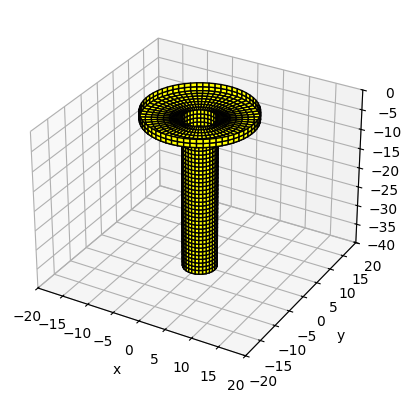

Panel Count:  1770
4


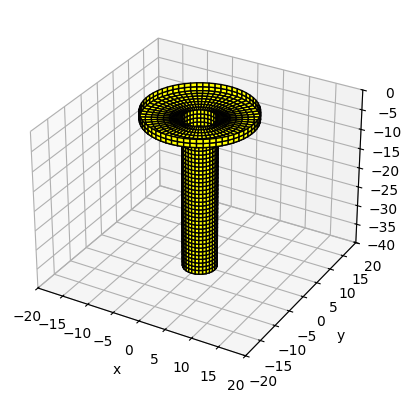

Panel Count:  1770
5


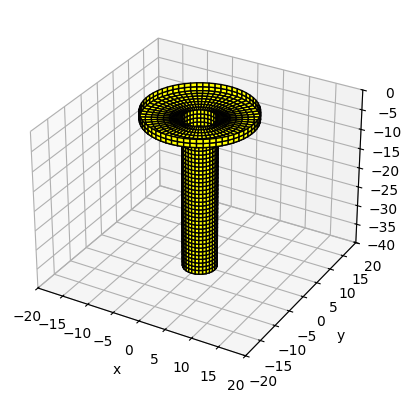

Panel Count:  1770
6


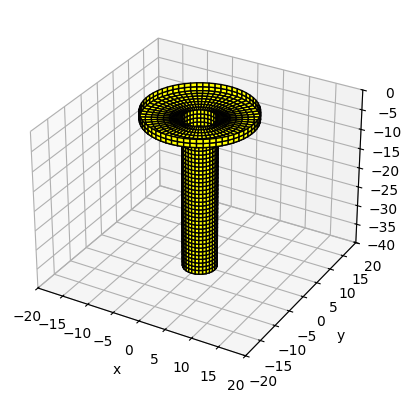

Panel Count:  1770
7


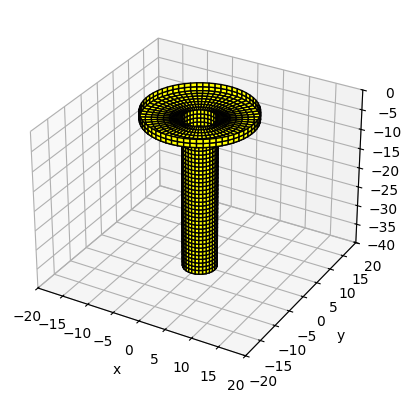

Panel Count:  1770
8


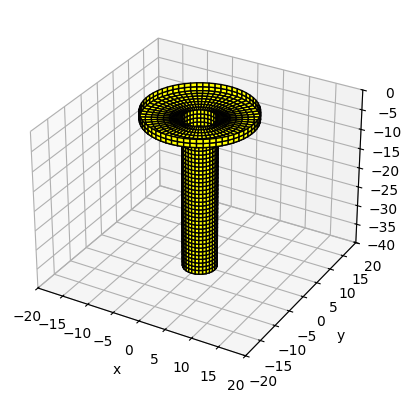

Panel Count:  1770
9


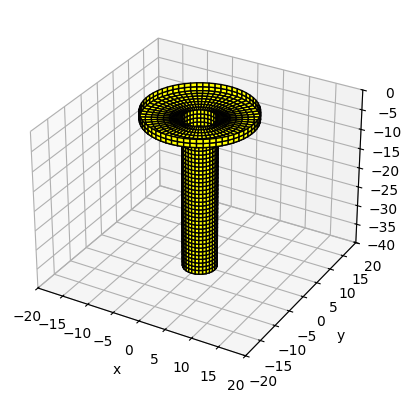

Panel Count:  1770


In [ ]:
# Run BEM
i = 1
d_in = d_list
d_out = d_list

A_BEM = np.zeros_like(omega_sweep)
B_BEM = np.zeros_like(omega_sweep)
F_ex_BEM = np.zeros(len(omega_sweep), dtype=np.complex128)

for j in range(len(omega_sweep)):
    
    print(j)

    omega = omega_sweep[j]
    config = {"name" : "config-(" + str(i) + ")",
                "h" : h,
                "a" : a_list,
                "d_in" : d_in,
                "d_out" : d_out,
                "heaving": [0, 1],
                "NMK" : [100, 100],
                "omega" : omega,
                "rho" : rho}
    Capy_results = compute_cpt_slant(config)
    A_BEM[j] = Capy_results[0]
    B_BEM[j] = Capy_results[1]
    F_ex_BEM[j] = Capy_results[2]

In [ ]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 18 # x and y label font size
leg_fs = lab_fs * 0.85 # legend font size
fig_h = 6 # figure height
fig_w = 5 # figure width

plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
colors = {
"pure_black": "#000000",
"dark_gray": "#252525",
"medium_gray": "#676767",
"pure_white": "#ffffff",
"midnight_navy": "#171723",
"deep_teal": "#004949",
"cyan_teal": "#009999",
"bright_green": "#22cf22",
"deep_purple": "#490092",
"royal_blue": "#006ddb",
"lavender": "#b66dff",
"hot_pink": "#ff6db6",
"crimson_red": "#920000",
"burnt_orange": "#8f4e00",
"vivid_orange": "#db6d00",
"soft_yellow": "#ffdf4d"
}

In [102]:
# Get limits of plots
x_max_lim = 1.05*np.max(omega_sweep)
x_min_lim = np.min(omega_sweep) - 0.05*np.max(omega_sweep)

A_max_lim = 1.05*np.max([A_MEEM.squeeze(),A_BEM.squeeze()])
B_max_lim = 1.05*np.max([B_MEEM.squeeze(),B_BEM.squeeze()])

x_scale = x_max_lim-x_min_lim
y_scale = A_max_lim

In [103]:
max_y_val = A_max_lim
frac_of_plot = 0.3
x_shift_scale = 0.9
y_shift_scale = 0.9

xy_translation = [x_scale*x_shift_scale + x_min_lim, max_y_val*y_shift_scale]

In [104]:
def get_scaled_geom(a_list, d_in, d_out, frac_of_plot, xy_translation, x_scale, y_scale):
    normalization_factor = np.max([a_list, d_in, d_out]) 

    RHS_coords = css.get_points(a_list, d_in, d_out)
    x_coords, y_coords = map(np.array, zip(*RHS_coords))

    x_total = np.concatenate([-x_coords[::-1], x_coords])
    y_total = np.concatenate([y_coords[::-1], y_coords])

    x_final = frac_of_plot*(x_scale/normalization_factor) * x_total + xy_translation[0]
    y_final = frac_of_plot*(y_scale/normalization_factor)* y_total + xy_translation[1]
    return x_final, y_final

x_final, y_final = get_scaled_geom(a_list, d_in, d_out, frac_of_plot, xy_translation, x_scale, y_scale)

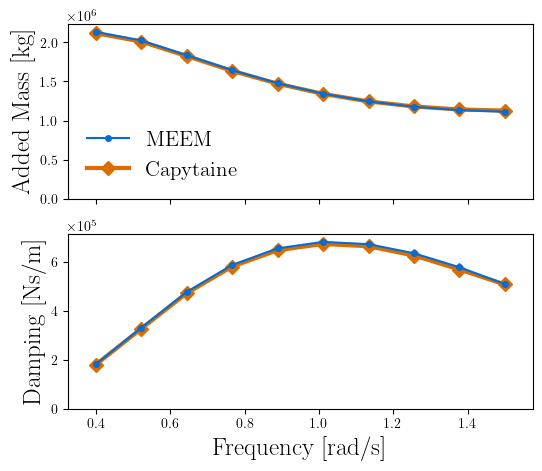

In [105]:
fig, ax = plt.subplots(2, 1, figsize=(fig_h, fig_w), sharex=True)
for a in ax:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)

ax[0].plot(omega_sweep, 
           A_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors["royal_blue"], 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=2)
ax[0].plot(omega_sweep, 
           A_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors["vivid_orange"], 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)

# ax[0].fill(x_final, y_final, color=[0.7,0.7,0.7], edgecolor='black')

ax[0].set_ylim([0, A_max_lim])
ax[0].set_xlim([x_min_lim, x_max_lim])
# ax[0].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[0].set_ylabel('Added Mass [kg]', fontsize=lab_fs)
ax[0].legend(loc='lower left', fontsize=leg_fs, frameon=False)


ax[1].plot(omega_sweep, 
           B_MEEM.squeeze(),
           marker='o', 
           linestyle='-', 
           color=colors["royal_blue"], 
           label='MEEM', 
           linewidth=l_width-1.5,
           markersize=m_size-3,
           zorder=2)
ax[1].plot(omega_sweep, 
           B_BEM.squeeze(), 
           marker='D',
           linestyle='-', 
           color=colors["vivid_orange"], 
           label='Capytaine', 
           linewidth=l_width,
           markersize=m_size,
           zorder=1)
ax[1].set_ylim([0, B_max_lim])
ax[1].set_xlim([x_min_lim, x_max_lim])
ax[1].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[1].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)
full_path = r"C:\Users\15183\OpenFLASH\pubs\JFM\figs\MEEM_vs_Capytaine_Nonslant_Validation.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')

In [ ]:
# bbox = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# ax_width_inch, ax_height_inch = bbox.width, bbox.height

# x_unit_per_inch = x_scale / ax_width_inch
# y_unit_per_inch = y_scale / ax_height_inch

# visual_correction = y_unit_per_inch / x_unit_per_inch


# def get_scaled_geom(a_list, d_in, d_out, frac_of_plot, xy_translation, x_scale, y_scale, visual_correction):
#     # Use the same normalization for both to maintain proportions
#     normalization_factor = np.max([np.max(a_list), np.max(d_in), np.max(d_out)]) 

#     RHS_coords = css.get_points(a_list, d_in, d_out)
#     x_coords, y_coords = map(np.array, zip(*RHS_coords))

#     x_total = np.concatenate([-x_coords[::-1], x_coords])
#     y_total = np.concatenate([y_coords[::-1], y_coords])

#     x_final = (frac_of_plot * x_scale / normalization_factor) * x_total + xy_translation[0]
    

#     base_geom_scale = (frac_of_plot * x_scale / normalization_factor)
#     y_final = (base_geom_scale * visual_correction) * y_total + xy_translation[1]
    
#     return x_final, y_final

# x_final, y_final = get_scaled_geom(a_list, d_in, d_out, frac_of_plot, xy_translation, 
#                                    x_scale, y_scale, visual_correction)

In [74]:
A_error = 100 * np.mean(np.abs((A_MEEM.values.squeeze()-A_BEM.squeeze())/A_BEM.squeeze()))
B_error = 100 * np.mean(np.abs((B_MEEM.values.squeeze()-B_BEM.squeeze())/B_BEM.squeeze()))
print('Added mass is ' + str(A_error)+ ' percent off')
print('Damping is ' + str(B_error) + ' percent off')

Added mass is 0.5723315566953874 percent off
Damping is 1.143165198292036 percent off
